In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import accuracy_score, classification_report


## Reading in the data and getting and overview

In [2]:
# Starting with 10k observations that have NA values filled from KNN imputation
df0 = pd.read_csv('na_filled_df.csv')
df0 = df0.sample(n=10000, random_state=2023)
df = df0
df.shape

(10000, 82)

In [3]:
print(df.head())
df.columns

       activity_year  derived_msa-md  county_code  census_tract  action_taken  \
39134         2019.0         19804.0      26163.0  2.616358e+10           3.0   
29924         2019.0         41180.0      29189.0  2.918922e+10           4.0   
23500         2019.0         36740.0      12095.0  1.209502e+10           4.0   
48363         2019.0         11244.0       6059.0  6.059022e+09           1.0   
20511         2019.0         18140.0      39159.0  3.915905e+10           1.0   

       purchaser_type  preapproval  loan_type  loan_purpose  lien_status  ...  \
39134             0.0          2.0        1.0          31.0          1.0  ...   
29924             0.0          2.0        1.0           1.0          1.0  ...   
23500             0.0          2.0        1.0          32.0          1.0  ...   
48363             1.0          2.0        1.0          31.0          1.0  ...   
20511             0.0          2.0        1.0           4.0          2.0  ...   

           derived_loan_pr

Index(['activity_year', 'derived_msa-md', 'county_code', 'census_tract',
       'action_taken', 'purchaser_type', 'preapproval', 'loan_type',
       'loan_purpose', 'lien_status', 'reverse_mortgage',
       'open-end_line_of_credit', 'business_or_commercial_purpose',
       'loan_amount', 'loan_to_value_ratio', 'interest_rate', 'rate_spread',
       'hoepa_status', 'total_loan_costs', 'origination_charges',
       'discount_points', 'lender_credits', 'loan_term',
       'prepayment_penalty_term', 'intro_rate_period', 'negative_amortization',
       'interest_only_payment', 'balloon_payment',
       'other_nonamortizing_features', 'property_value', 'construction_method',
       'occupancy_type', 'manufactured_home_secured_property_type',
       'manufactured_home_land_property_interest', 'income',
       'debt_to_income_ratio', 'applicant_credit_score_type',
       'co-applicant_credit_score_type', 'applicant_ethnicity-1',
       'applicant_ethnicity-2', 'co-applicant_ethnicity-1',
    

action_taken
1.0    52.75
3.0    14.16
4.0    12.93
6.0    12.89
5.0     4.06
2.0     2.22
8.0     0.50
7.0     0.49
Name: count, dtype: float64


c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='action_taken', ylabel='count'>

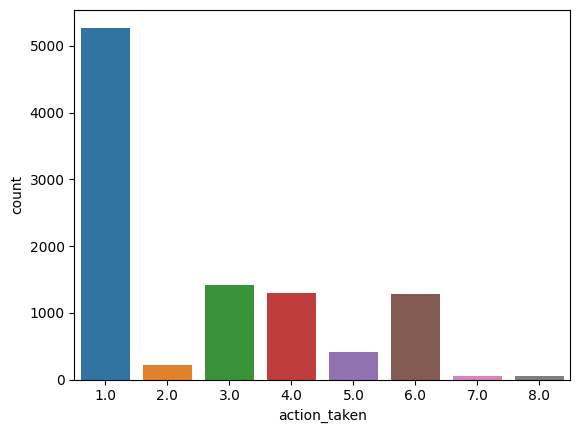

In [4]:
# Looking at the percentage of each action type
print(df['action_taken'].value_counts()/len(df)*100)
sns.countplot(x='action_taken', data=df)

In [5]:
# Converting target variable to binary
df['action_taken'] = df['action_taken'].apply(lambda x: 1 if x in [1,2,6] else 0)

****

### Data cleaning and feature selection

In [6]:
# Dropping denial reason because it perfectly predicts approval or denial 
# Dropping lei because it is not feasible to make every financial institution into a dummy variable
df = df.drop(columns=['denial_reason-1', 'denial_reason-2', 'lei'])

In [7]:
# Finding categorical variables
string_columns = df.select_dtypes(include=['object']).columns
string_df = df[string_columns]
print(string_columns)

Index(['state_code', 'conforming_loan_limit', 'derived_loan_product_type',
       'derived_dwelling_category', 'derived_ethnicity', 'derived_race',
       'derived_sex', 'total_units', 'applicant_age', 'co-applicant_age',
       'applicant_age_above_62', 'co-applicant_age_above_62'],
      dtype='object')


In [8]:
# Seeing how many unique values each category has
unique_counts = {}

for column in string_columns:
    unique_counts[column] = df[column].nunique()

unique_counts

{'state_code': 52,
 'conforming_loan_limit': 3,
 'derived_loan_product_type': 6,
 'derived_dwelling_category': 4,
 'derived_ethnicity': 5,
 'derived_race': 9,
 'derived_sex': 4,
 'total_units': 8,
 'applicant_age': 8,
 'co-applicant_age': 9,
 'applicant_age_above_62': 2,
 'co-applicant_age_above_62': 2}

In [9]:
# Making sure these are strings and not mixed data types
df['applicant_sex'] = df['applicant_sex'].astype(str)
df['applicant_age_above_62'] = df['applicant_age_above_62'].astype(str)
df['derived_race'] = df['derived_race'].astype(str)
df_dummies = pd.get_dummies(df, columns=string_columns, drop_first=True)
df_dummies.shape

(10000, 168)

## Building a logistic regression model

In [11]:
# Splitting the data
y = df_dummies['action_taken']
X = df_dummies.drop(columns='action_taken')
# Inlcuding the sensitive features also to use later in Fairlearn
sensitive_features_data = df[['applicant_sex', 'applicant_age_above_62', 'derived_race']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2023)
sensitive_features_train, sensitive_features_test = train_test_split(sensitive_features_data, test_size=0.25, random_state=2023)

Confusion Matrix:


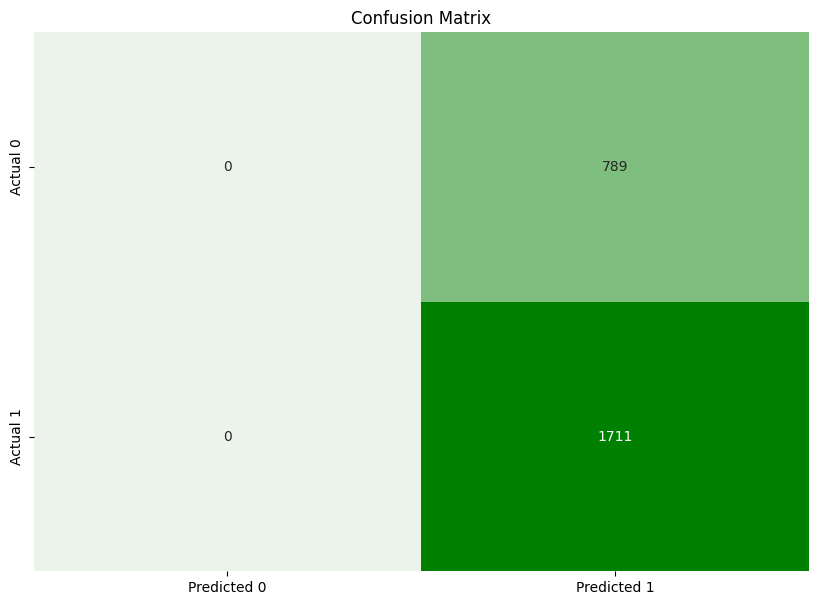

In [12]:
# Building the logistic regression model
log_reg_0 = LogisticRegression()
log_reg_0.fit(X_train, y_train)

# Generating predictions and displaying the confusion matrix
y_pred = log_reg_0.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
# Create a custom color map
cmap = sns.light_palette("green", as_cmap=True)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix')
plt.show()

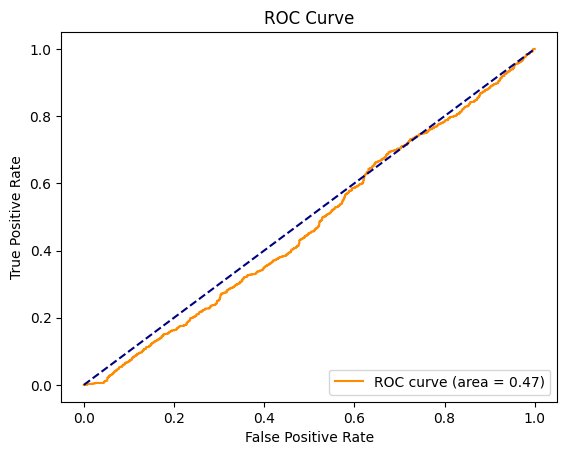

In [13]:
# Plotting the ROC curve
y_prob = log_reg_0.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()  

****

## Looking into metrics with Microsoft Fairlearn

In [25]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate

In [19]:
sensitive_features_test

,applicant_sex,applicant_age_above_62,derived_race
24325,1.0,No,White
2146,4.0,nan,Race Not Available
2629,1.0,Yes,White
39365,2.0,No,White
12966,1.0,No,White
...,...,...,...
4833,1.0,Yes,White
35914,4.0,nan,Race Not Available
31585,1.0,No,White
20726,1.0,No,Asian


In [24]:
# Accuracy by race
mf = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['derived_race'])
print(mf.overall)
mf.by_group

0.6844


c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)


derived_race
2 or more minority races                     0.666667
American Indian or Alaska Native             0.636364
Asian                                        0.676471
Black or African American                    0.522222
Free Form Text Only                          0.000000
Joint                                        0.688889
Native Hawaiian or Other Pacific Islander    0.625000
Race Not Available                           0.751323
White                                        0.680354
Name: accuracy_score, dtype: float64

In [26]:
# Selection rate is the percentage of the population that is labeled '1'
sr = MetricFrame(metrics=selection_rate, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['derived_race'])
print(sr.overall)
sr.by_group

1.0


c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)


derived_race
2 or more minority races                     1.0
American Indian or Alaska Native             1.0
Asian                                        1.0
Black or African American                    1.0
Free Form Text Only                          1.0
Joint                                        1.0
Native Hawaiian or Other Pacific Islander    1.0
Race Not Available                           1.0
White                                        1.0
Name: selection_rate, dtype: float64

In [36]:
# Manually defining FPR and FNR
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Define False Positive Rate
def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn)

# Define False Negative Rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

# Define Selection Rate
def selection_rate(y_true, y_pred):
    return sum(y_pred) / len(y_pred)

# Define Count (this is simply the length of y_pred)
def count(y_true, y_pred):
    return len(y_pred)

C:\Users\Emerson\AppData\Local\Temp\ipykernel_12844\1836345805.py:12: RuntimeWarning: invalid value encountered in scalar divide
  return fn / (fn + tp)
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x)

array([[<Axes: title={'center': 'accuracy'}, xlabel='derived_race'>,
        <Axes: title={'center': 'precision'}, xlabel='derived_race'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='derived_race'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='derived_race'>,
        <Axes: title={'center': 'selection rate'}, xlabel='derived_race'>,
        <Axes: title={'center': 'count'}, xlabel='derived_race'>],
       [<Axes: xlabel='derived_race'>, <Axes: xlabel='derived_race'>,
        <Axes: xlabel='derived_race'>]], dtype=object)

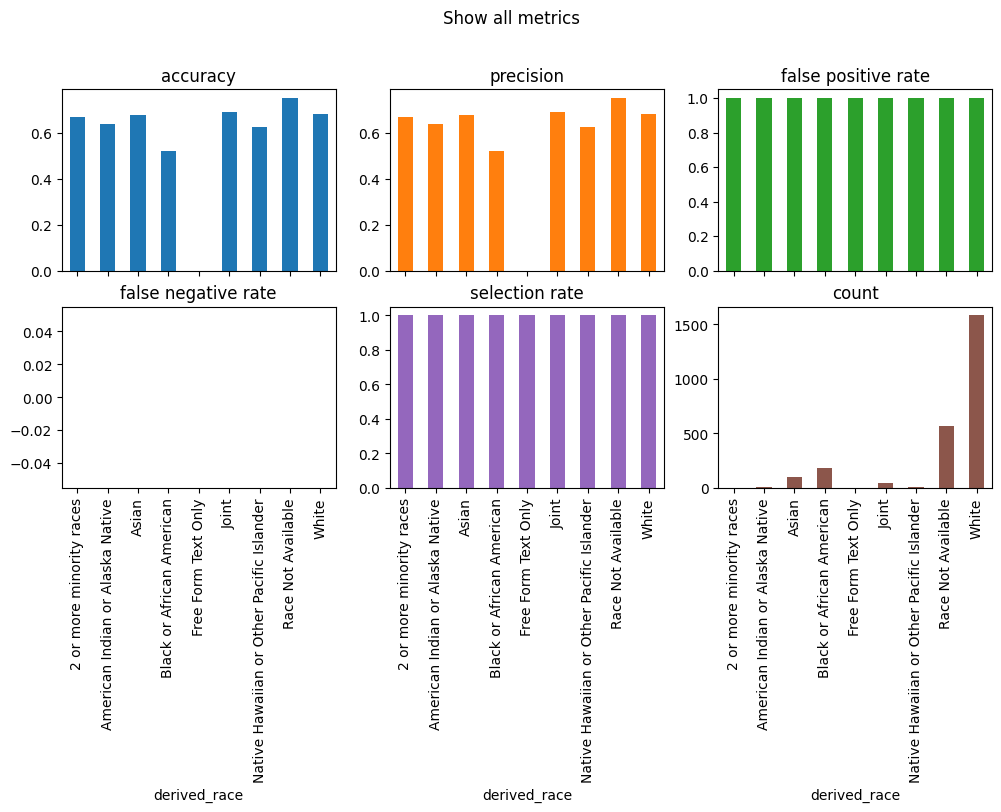

In [37]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['derived_race'])

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)